In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from os.path import dirname, join

# Simple Car Classificator

In [ ]:
from sklearn.model_selection import train_test_split

data = np.load('./tests/00_unittest_classifier_input/train_data.npz')
X = data['X'].reshape(-1, 1, 40, 100).transpose(0, 2, 3, 1)   #pytorch dimensions are (N, C, H, W)
y = data['y'].astype(np.int64)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

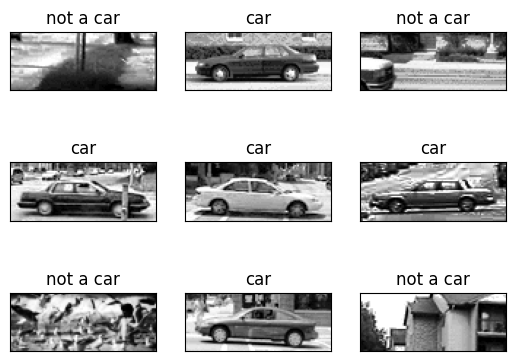

In [4]:
fig, ax = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        idx = np.random.randint(len(X_train))
        ax[i][j].set_title('car' if y_train[idx]==1 else 'not a car')
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        ax[i][j].imshow(X_train[idx, :, :, 0], cmap='grey')
        

In [15]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.HorizontalFlip(.5),
    A.ShiftScaleRotate(shift_limit=.05, scale_limit=.1, rotate_limit=10, p=.7),
    A.CoarseDropout(num_holes_range=(2, 4), hole_width_range=(0.05, 0.2), hole_height_range=(0.05, 0.2), p=.5),
    # A.OneOf([
    #     A.GaussianBlur(blur_limit=(3, 5), p=0.5),
    #     A.MotionBlur(blur_limit=(3, 5), p=0.5),
    # ], p=0.25),
    A.GaussNoise(std_range=(.001, .02), p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=[0.45], std=[0.27], max_pixel_value=1.0),
    ToTensorV2()
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

/Users/ruslanf/Library/Python/3.9/lib/python/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [16]:
from cars_detection import CarsClassifierDataset
from torch.utils.data import DataLoader
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

batch_size = 64

train_dataset = CarsClassifierDataset(X_train, y_train, transform=transform)
val_dataset = CarsClassifierDataset(X_train, y_train) # not a good practice
test_dataset = CarsClassifierDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [1361]:
from torch import nn

class SqueezeExcite(nn.Module):
    def __init__(self, channel, reduction=8):
        super(SqueezeExcite, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.GELU(),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class CarsClassificationModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(1, 32, 3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(32),
                nn.GELU(),
                SqueezeExcite(32),
                nn.MaxPool2d(2, 2),
            ),
            nn.Sequential(
                nn.Conv2d(32, 64, 3, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.GELU(),
                SqueezeExcite(64),
                nn.MaxPool2d(2, 2),
                nn.Dropout2d(.1)
            ),
            nn.Sequential(
                nn.Conv2d(64, 64, 5, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.GELU(),
                nn.Conv2d(64, 128, 5, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.GELU(),
                SqueezeExcite(128),
                # nn.MaxPool2d(2, 2),
                nn.Dropout2d(.2)
            )
        )
        
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = self.fc(torch.flatten(x, 1))
        return x
    
classification_model = CarsClassificationModel()
classification_model.to(device)

CarsClassificationModel(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): SqueezeExcite(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=False)
          (1): GELU(approximate='none')
          (2): Linear(in_features=4, out_features=32, bias=False)
          (3): Sigmoid()
        )
      )
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): SqueezeExcite(
        (avg_pool): AdaptiveAvgPool2d(

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1 - train accuracy: 0.7510 - train loss: 0.5279 - val accuracy: 0.6595 - val loss: 1.3848
Validation accuracy improved (0.0000 --> 0.6595). Saving model...


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2 - train accuracy: 0.8996 - train loss: 0.2555 - val accuracy: 0.8729 - val loss: 0.3837
Validation accuracy improved (0.6595 --> 0.8729). Saving model...


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3 - train accuracy: 0.9263 - train loss: 0.1864 - val accuracy: 0.9606 - val loss: 0.1019
Validation accuracy improved (0.8729 --> 0.9606). Saving model...


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4 - train accuracy: 0.9288 - train loss: 0.1602 - val accuracy: 0.9746 - val loss: 0.0628
Validation accuracy improved (0.9606 --> 0.9746). Saving model...


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5 - train accuracy: 0.9314 - train loss: 0.1939 - val accuracy: 0.9682 - val loss: 0.0918
Validation accuracy did not improve. Counter: 1/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6 - train accuracy: 0.9517 - train loss: 0.1313 - val accuracy: 0.9530 - val loss: 0.1137
Validation accuracy did not improve. Counter: 2/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7 - train accuracy: 0.9568 - train loss: 0.0986 - val accuracy: 0.9835 - val loss: 0.0440
Validation accuracy improved (0.9746 --> 0.9835). Saving model...


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8 - train accuracy: 0.9657 - train loss: 0.0977 - val accuracy: 0.9911 - val loss: 0.0273
Validation accuracy improved (0.9835 --> 0.9911). Saving model...


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9 - train accuracy: 0.9670 - train loss: 0.0782 - val accuracy: 0.9860 - val loss: 0.0368
Validation accuracy did not improve. Counter: 1/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10 - train accuracy: 0.9657 - train loss: 0.0970 - val accuracy: 0.9873 - val loss: 0.0361
Validation accuracy did not improve. Counter: 2/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11 - train accuracy: 0.9657 - train loss: 0.0832 - val accuracy: 0.9835 - val loss: 0.0534
Validation accuracy did not improve. Counter: 3/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12 - train accuracy: 0.9759 - train loss: 0.0632 - val accuracy: 0.9911 - val loss: 0.0194
Validation accuracy did not improve. Counter: 4/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13 - train accuracy: 0.9784 - train loss: 0.0504 - val accuracy: 0.9911 - val loss: 0.0202
Validation accuracy did not improve. Counter: 5/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14 - train accuracy: 0.9809 - train loss: 0.0520 - val accuracy: 0.9924 - val loss: 0.0175
Validation accuracy improved (0.9911 --> 0.9924). Saving model...


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15 - train accuracy: 0.9784 - train loss: 0.0598 - val accuracy: 0.9924 - val loss: 0.0223
Validation accuracy did not improve. Counter: 1/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16 - train accuracy: 0.9759 - train loss: 0.0703 - val accuracy: 0.9924 - val loss: 0.0155
Validation accuracy did not improve. Counter: 2/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17 - train accuracy: 0.9860 - train loss: 0.0447 - val accuracy: 0.9975 - val loss: 0.0118
Validation accuracy improved (0.9924 --> 0.9975). Saving model...


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18 - train accuracy: 0.9848 - train loss: 0.0374 - val accuracy: 0.9936 - val loss: 0.0148
Validation accuracy did not improve. Counter: 1/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19 - train accuracy: 0.9822 - train loss: 0.0540 - val accuracy: 0.9924 - val loss: 0.0175
Validation accuracy did not improve. Counter: 2/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20 - train accuracy: 0.9873 - train loss: 0.0327 - val accuracy: 0.9924 - val loss: 0.0177
Validation accuracy did not improve. Counter: 3/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 21 - train accuracy: 0.9848 - train loss: 0.0423 - val accuracy: 0.9975 - val loss: 0.0123
Validation accuracy did not improve. Counter: 4/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 22 - train accuracy: 0.9797 - train loss: 0.0518 - val accuracy: 0.9936 - val loss: 0.0140
Validation accuracy did not improve. Counter: 5/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 23 - train accuracy: 0.9822 - train loss: 0.0401 - val accuracy: 0.9962 - val loss: 0.0111
Validation accuracy did not improve. Counter: 6/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 24 - train accuracy: 0.9975 - train loss: 0.0184 - val accuracy: 0.9975 - val loss: 0.0075
Validation accuracy did not improve. Counter: 7/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 25 - train accuracy: 0.9886 - train loss: 0.0292 - val accuracy: 0.9975 - val loss: 0.0065
Validation accuracy did not improve. Counter: 8/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 26 - train accuracy: 0.9886 - train loss: 0.0422 - val accuracy: 0.9962 - val loss: 0.0067
Validation accuracy did not improve. Counter: 9/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 27 - train accuracy: 0.9886 - train loss: 0.0276 - val accuracy: 0.9975 - val loss: 0.0073
Validation accuracy did not improve. Counter: 10/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 28 - train accuracy: 0.9860 - train loss: 0.0319 - val accuracy: 0.9962 - val loss: 0.0082
Validation accuracy did not improve. Counter: 11/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 29 - train accuracy: 0.9873 - train loss: 0.0301 - val accuracy: 0.9975 - val loss: 0.0082
Validation accuracy did not improve. Counter: 12/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 30 - train accuracy: 0.9962 - train loss: 0.0166 - val accuracy: 0.9975 - val loss: 0.0076
Validation accuracy did not improve. Counter: 13/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 31 - train accuracy: 0.9924 - train loss: 0.0217 - val accuracy: 0.9962 - val loss: 0.0067
Validation accuracy did not improve. Counter: 14/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 32 - train accuracy: 0.9886 - train loss: 0.0253 - val accuracy: 0.9962 - val loss: 0.0070
Validation accuracy did not improve. Counter: 15/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 33 - train accuracy: 0.9886 - train loss: 0.0292 - val accuracy: 0.9962 - val loss: 0.0060
Validation accuracy did not improve. Counter: 16/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 34 - train accuracy: 0.9911 - train loss: 0.0291 - val accuracy: 0.9962 - val loss: 0.0065
Validation accuracy did not improve. Counter: 17/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 35 - train accuracy: 0.9924 - train loss: 0.0214 - val accuracy: 0.9975 - val loss: 0.0055
Validation accuracy did not improve. Counter: 18/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 36 - train accuracy: 0.9809 - train loss: 0.0404 - val accuracy: 0.9975 - val loss: 0.0070
Validation accuracy did not improve. Counter: 19/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 37 - train accuracy: 0.9911 - train loss: 0.0263 - val accuracy: 0.9975 - val loss: 0.0055
Validation accuracy did not improve. Counter: 20/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 38 - train accuracy: 0.9911 - train loss: 0.0267 - val accuracy: 0.9975 - val loss: 0.0051
Validation accuracy did not improve. Counter: 21/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 39 - train accuracy: 0.9936 - train loss: 0.0208 - val accuracy: 0.9987 - val loss: 0.0045
Validation accuracy improved (0.9975 --> 0.9987). Saving model...


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 40 - train accuracy: 0.9962 - train loss: 0.0194 - val accuracy: 0.9975 - val loss: 0.0054
Validation accuracy did not improve. Counter: 1/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 41 - train accuracy: 0.9886 - train loss: 0.0256 - val accuracy: 0.9975 - val loss: 0.0052
Validation accuracy did not improve. Counter: 2/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 42 - train accuracy: 0.9924 - train loss: 0.0187 - val accuracy: 0.9975 - val loss: 0.0053
Validation accuracy did not improve. Counter: 3/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 43 - train accuracy: 0.9936 - train loss: 0.0201 - val accuracy: 0.9987 - val loss: 0.0048
Validation accuracy did not improve. Counter: 4/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 44 - train accuracy: 0.9924 - train loss: 0.0202 - val accuracy: 1.0000 - val loss: 0.0036
Validation accuracy improved (0.9987 --> 1.0000). Saving model...


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 45 - train accuracy: 0.9886 - train loss: 0.0230 - val accuracy: 0.9987 - val loss: 0.0040
Validation accuracy did not improve. Counter: 1/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 46 - train accuracy: 0.9962 - train loss: 0.0171 - val accuracy: 0.9987 - val loss: 0.0039
Validation accuracy did not improve. Counter: 2/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 47 - train accuracy: 0.9886 - train loss: 0.0275 - val accuracy: 1.0000 - val loss: 0.0031
Validation accuracy did not improve. Counter: 3/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 48 - train accuracy: 0.9936 - train loss: 0.0163 - val accuracy: 1.0000 - val loss: 0.0033
Validation accuracy did not improve. Counter: 4/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 49 - train accuracy: 0.9949 - train loss: 0.0219 - val accuracy: 1.0000 - val loss: 0.0033
Validation accuracy did not improve. Counter: 5/25


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 50 - train accuracy: 0.9924 - train loss: 0.0194 - val accuracy: 0.9987 - val loss: 0.0034
Validation accuracy did not improve. Counter: 6/25
Finished Training. Loaded best model.


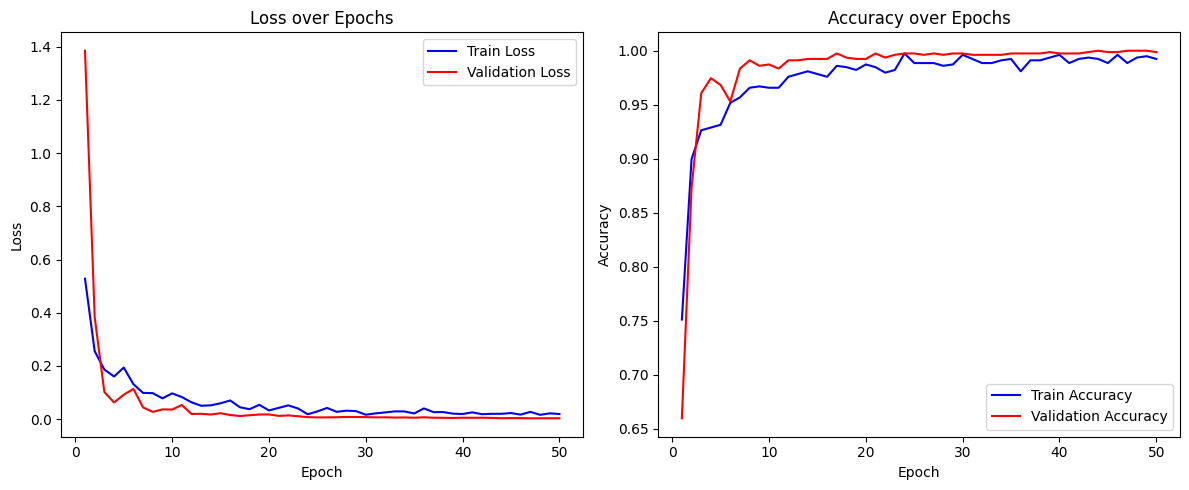

Test accuracy: 0.992395


In [ ]:
from cars_detection import train_model, evaluate_model

model_path='cars_classification_1.pth'
train_model(classification_model, train_loader, val_loader, epochs=50, lr=.01, lr_ratio=1e-2, model_path=model_path, device=device)
evaluate_model(classification_model, test_loader, device=device)

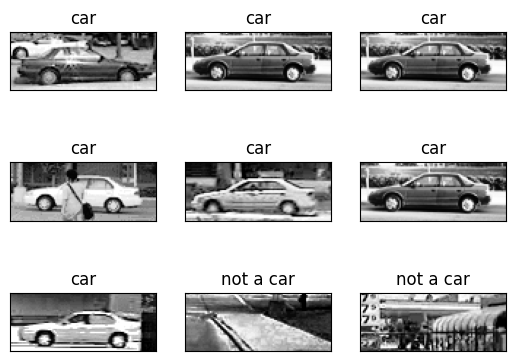

In [1365]:
classification_model.eval()
test_predictions = []
with torch.no_grad():
    for data in test_loader:
        inputs, targets = data[0].to(device), data[1].to(device).float()
        outputs = classification_model(inputs).squeeze(1)
        test_predictions.append(outputs)
        
test_predictions = np.hstack([(predictions>0).cpu().numpy() for predictions in test_predictions])
fig, ax = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        idx = np.random.randint(len(test_dataset))
        ax[i][j].set_title('car' if test_predictions[idx]==1 else 'not a car')
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        ax[i][j].imshow(test_dataset[idx][0][0], cmap='grey')


In [1366]:
def get_detection_model(classification_model):
    features_layer = classification_model.features
    fc_layer = {
        'weights': classification_model.fc.weight.data,
        'bias': classification_model.fc.bias.data
    }
    detection_layer = nn.Conv2d(
        in_channels=fc_layer['weights'].shape[1],
        out_channels=fc_layer['weights'].shape[0],
        kernel_size=1,
        bias=True
    )
    detection_layer.weight.data = fc_layer['weights'].view(fc_layer['weights'].shape[0], fc_layer['weights'].shape[1], 1, 1).clone()
    detection_layer.weight.data /= 15.0
    detection_layer.bias.data = fc_layer['bias'].clone()

    class CarsDetector(nn.Module):

        def __init__(self, convolution_layers, detection_layer):
            super().__init__()
            self.convolution_layers = convolution_layers
            self.detection_layer = detection_layer

        def forward(self, x):
            for convolution in self.convolution_layers:
                x = convolution(x)
            x = self.detection_layer(x)
            return x
    
    return CarsDetector(features_layer, detection_layer)
    
detection_model = get_detection_model(classification_model)

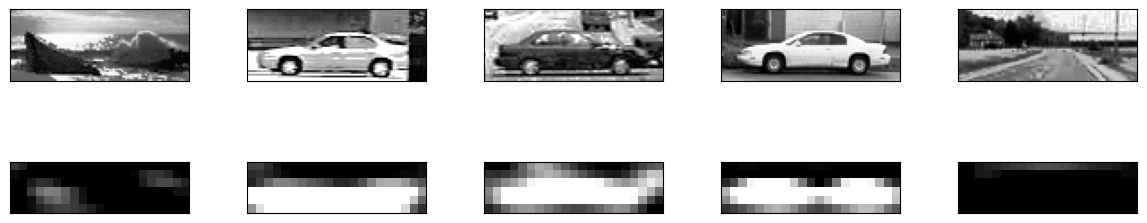

In [1368]:
detection_model.eval()

idx = np.random.randint(len(test_dataset))
fig, ax = plt.subplots(2, 5, figsize=(12, 3))
fig.tight_layout()

with torch.no_grad():
    for j in range(5):
        idx = np.random.randint(len(test_dataset))
        image = test_dataset[idx][0]
        detection = detection_model(image.to(device).unsqueeze(0))
        ax[0][j].set_xticks([])
        ax[1][j].set_xticks([])
        ax[0][j].set_yticks([])
        ax[1][j].set_yticks([])
        ax[0][j].imshow(image[0], cmap='grey')
        ax[1][j].imshow(detection[0, 0], cmap='grey', vmin=0, vmax=1)


# Bounding Boxes

In [1369]:
import os
import cv2
import json

test_folder = './tests/05_unittest_detector_nms_input'
images_dir = os.path.join(test_folder, 'test_imgs')
test_images = {}
for image_file in os.listdir(images_dir):
    test_images[image_file] = cv2.imread(os.path.join(images_dir, image_file))

with open('./tests/05_unittest_detector_nms_input/true_detections.json') as file:
    ground_truths = json.load(file)

for key, gt in ground_truths.items():
    ground_truths[key] = np.asarray(gt)
    ground_truths[key][:, 2:] += ground_truths[key][:, :2]
    ground_truths[key] = ground_truths[key].reshape(-1, 2, 2)[:, :, ::-1].reshape(-1, 4)

In [1541]:
from cars_detection import get_detections, visualize_bboxes

classification_model = torch.load('cars_classification.pth', map_location=device)
detection_model = get_detection_model(classification_model)

detections = get_detections(detection_model, test_images, confidence_threshold=.47, heatmap_blur=0)

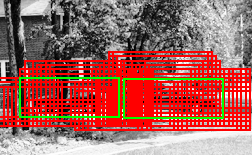

In [1542]:
visualization_file = 'test-108.png'
visualize_bboxes(test_images[visualization_file], detections[visualization_file], ground_truths[visualization_file])

# Precision-Recall & AUC

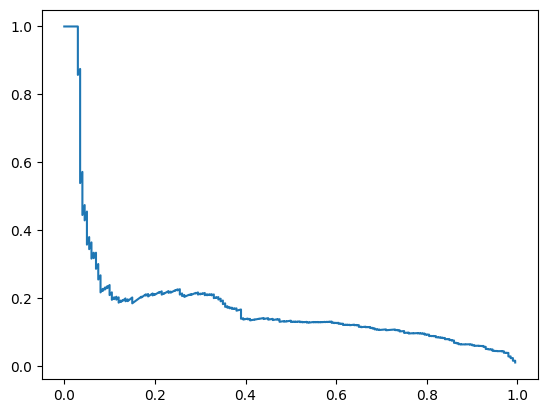

AUC: 0.1755756491709804


In [1543]:
from cars_detection import auc

precision_recall, auc_ = auc(detections, ground_truths, iou_threshold=.2)
plt.plot(precision_recall[:, 1], precision_recall[:, 0])
plt.show()
print(f'AUC: {auc_}')

# Non-Maximum Suppression

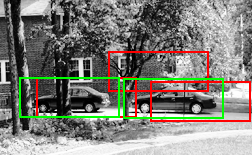

In [1544]:
from cars_detection import nms
iou_threshold = .1

filtered_detections = nms(detections, iou_threshold)
visualize_bboxes(test_images[visualization_file], filtered_detections[visualization_file], ground_truths[visualization_file])

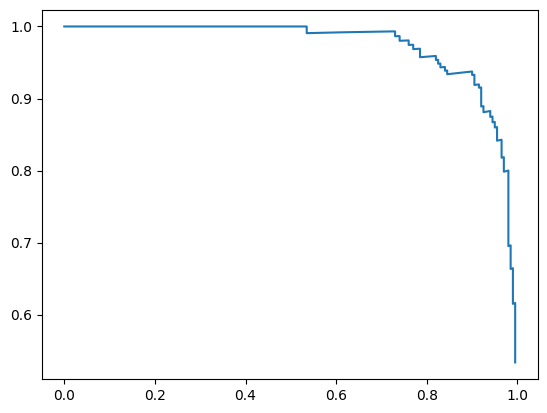

AUC: 0.9703393197828647


In [1545]:
precision_recall, auc_ = auc(filtered_detections, ground_truths, iou_threshold)
plt.plot(precision_recall[:, 1], precision_recall[:, 0])
plt.show()
print(f'AUC: {auc_}')